# <center> <b>Naive Bayes i k-NN algoritmi</b> </center>
## <center> Matematičke osnove strojnog učenja </center>
## <center> Prva domaća zadaća </center>
### <center> Doris Đivanović </center>

### Biblioteka Scikit-learn

Najprije ću instalirati `Scikit-learn` biblioteku u kojoj se nalaze moduli za algoritme *Naive Bayes* i *k-NN*.

In [ ]:
pip install pandas scikit-learn

## Podaci

### Izvor

*Dataset* na kojem ću provesti klasifikacijske algoritme preuzela sam s ***Kaggle***-a.\
Link: https://www.kaggle.com/datasets/apratik46/daily-weather-dataset?resource=download

Samo ime *dataset*-a kaže da su to **podaci o dnevnim vremenskim prilikama**.

### Učitavanje u DataFrame

Sada ću uključiti `pandas` biblioteku, s pomoću koje ću učitati csv datoteku s podacima u DataFrame objekt.

Provjerit ću broj redaka i stupaca u kojima se **nalaze** moji podaci. Podatke ću pregledati ispisujući prvih nekoliko redaka, da ne bih ispisivala cijelu tablicu.

In [ ]:
import pandas as pd

# Učitavanje podataka iz csv datoteke u pandas DataFrame objekt
weather_df = pd.read_csv('daily_weather.csv')

# Broj redaka i stupaca u DataFrame-u
num_rows, num_cols = weather_df.shape
print("Broj redaka:", num_rows)
print("Broj stupaca:", num_cols)

# Ispis nekoliko početnih redaka DataFrame-a
print(weather_df.head())

Broj redaka: 1095
Broj stupaca: 11
   number  air_pressure_9am  air_temp_9am  avg_wind_direction_9am  \
0       0        918.060000     74.822000              271.100000   
1       1        917.347688     71.403843              101.935179   
2       2        923.040000     60.638000               51.000000   
3       3        920.502751     70.138895              198.832133   
4       4        921.160000     44.294000              277.800000   

   avg_wind_speed_9am  max_wind_direction_9am  max_wind_speed_9am  \
0            2.080354              295.400000            2.863283   
1            2.443009              140.471548            3.533324   
2           17.067852               63.700000           22.100967   
3            4.337363              211.203341            5.190045   
4            1.856660              136.500000            2.863283   

   rain_accumulation_9am  rain_duration_9am  relative_humidity_9am  \
0                    0.0                0.0              42.42000

Podaci se, dakle, sastoje od vrijednosti za 10 svojstava vremena unutar jednog dana, za 1095 dana. Ukupan broj dana (1095), dakle, nije prevelik.

## Cilj

Željela bih na temelju ovakvih podataka, tj. **naziva danih varijabli**, klasifikacijskim algoritmima **odrediti kakvo je vrijeme bilo određenog dana s obzirom na četiri klase**: ***Sunčano***, ***Oblačno***, ***Vjetrovito*** i ***Kišno***. Ove mi se četiri klase čine kao moguće za zaključiti iz danih vremenskih svojstava, ali i dovoljno različite i **međusobno isključive** (do na vjetrovitost, ali, na primjer, vjetrovitost mogu uzimati u obzir ako je jako velika i prioritizirati ju pored ostalih).

## Priprema podataka

Iz gornjeg ispisa, vidim da je prvi stupac *number* broj retka, pa ću njega obrisati iz DataFrame-a.



In [ ]:
# Brisanje stupca 'number' iz DataFrame-a
weather_df = weather_df.drop(['number'], axis=1)

# Ispis kao potvrda
print(weather_df.head())

   air_pressure_9am  air_temp_9am  avg_wind_direction_9am  avg_wind_speed_9am  \
0        918.060000     74.822000              271.100000            2.080354   
1        917.347688     71.403843              101.935179            2.443009   
2        923.040000     60.638000               51.000000           17.067852   
3        920.502751     70.138895              198.832133            4.337363   
4        921.160000     44.294000              277.800000            1.856660   

   max_wind_direction_9am  max_wind_speed_9am  rain_accumulation_9am  \
0              295.400000            2.863283                    0.0   
1              140.471548            3.533324                    0.0   
2               63.700000           22.100967                    0.0   
3              211.203341            5.190045                    0.0   
4              136.500000            2.863283                    8.9   

   rain_duration_9am  relative_humidity_9am  relative_humidity_3pm  
0          

Nadalje, podaci za svih 10 svojstava vremena su očito **numerički**. To je dobro, jer algoritmi *Naive Bayes* i *k-NN* rade s numeričkim podacima, pa bismo eventualne opisne ili "kategoričke" podatke trebali kodirati brojevima.

U tip vrijednosti svojih podataka mogu se uvjeriti, npr. sljedećom naredbom:

In [ ]:
print(weather_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   air_pressure_9am        1092 non-null   float64
 1   air_temp_9am            1090 non-null   float64
 2   avg_wind_direction_9am  1091 non-null   float64
 3   avg_wind_speed_9am      1092 non-null   float64
 4   max_wind_direction_9am  1092 non-null   float64
 5   max_wind_speed_9am      1091 non-null   float64
 6   rain_accumulation_9am   1089 non-null   float64
 7   rain_duration_9am       1092 non-null   float64
 8   relative_humidity_9am   1095 non-null   float64
 9   relative_humidity_3pm   1095 non-null   float64
dtypes: float64(10)
memory usage: 85.7 KB
None


## Nedostajuće vrijednosti

Ukoliko neke vrijednosti u podacima nedostaju, posebno ako je takvih relativno puno, može doći do grešaka i pristranosti tijekom treniranja modela. Stoga je takve vrijednosti potrebno **eliminirati**. Ukoliko ih je relativno malo, moguće je **izbaciti** pripadne retke ili stupce (ovisno o situaciji) iz podataka koje promatramo. Ukoliko ih je relativno puno, takve je vrijednosti potrebno **nekako odrediti**.

Provjeru sadrže li moji podaci nedefinirane vrijednosti provest ću sljedećom naredbom:

In [ ]:
print(weather_df.isnull().sum())

air_pressure_9am          3
air_temp_9am              5
avg_wind_direction_9am    4
avg_wind_speed_9am        3
max_wind_direction_9am    3
max_wind_speed_9am        4
rain_accumulation_9am     6
rain_duration_9am         3
relative_humidity_9am     0
relative_humidity_3pm     0
dtype: int64


Vidim, dakle, da prvih 8 stupaca mojih podataka sadrži po nekoliko nedostajućih vrijednosti. Brojke nisu velike, pa bih pripadne retke mogla samo obrisati iz DataFrame-a, ali ću ipak, u svrhu vježbe i učenja, odrediti na koji ću način te vrijednosti definirati.

Nedostajuće numeričke vrijednosti se standardno zamjenjuju **aritmetičkom sredinom** ili **medijanom** preostalih, dakle definiranih, vrijednosti pripadne varijable. Aritmetička sredina je pogodna za podatke koji su **normalno distribuirani**, a medijan za podatke koji imaju **outlier-e**. Za opisne, nenumeričke, vrijednosti najčešće se uzima vrijednost koja se najčešće pojavljue, dakle **mod** pripadne varijable.

Moji su podaci numerički, pa ću analizirati podatke za svaku od 8 varijabli za koju postoje nedostajuće vrijednosti. Analizirat ću **distribuciju** svake od tih varijabli, **grafički** i **statistički**.





### Analiza distribucija varijabli s pomoću histograma i box plot-a

Budući da želim vidjeti jesu li moji podaci  simetrično distribuirani, kao i sadrže li outliere, nacrtat ću pripadne **histograme** i **box-plot-ove**.

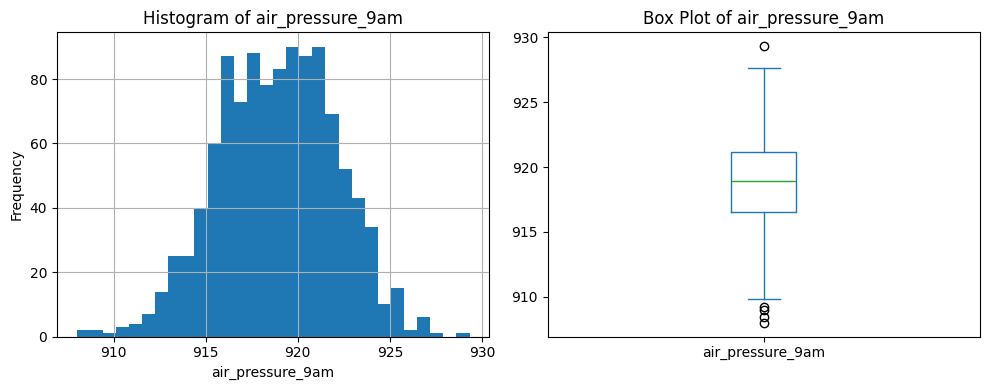

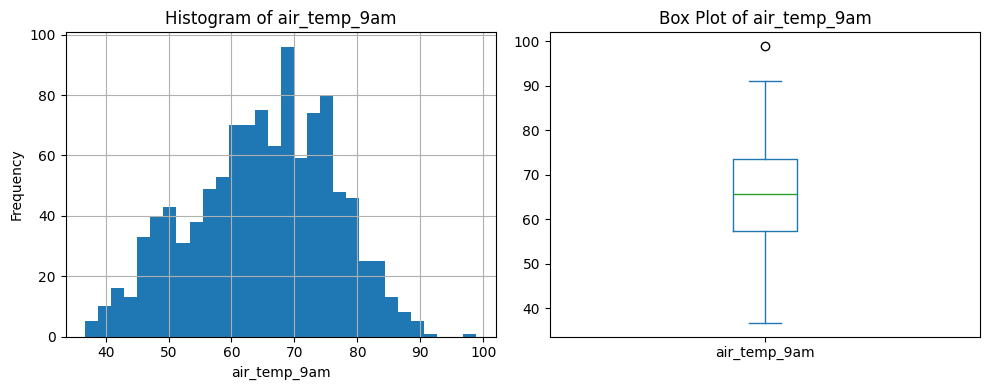

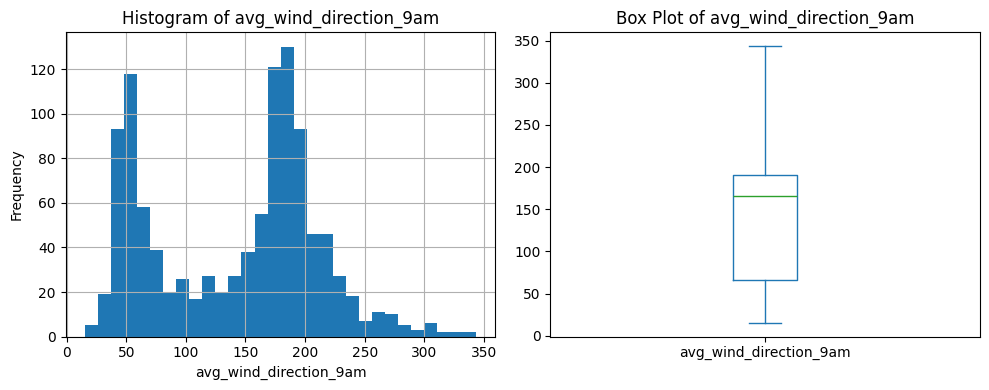

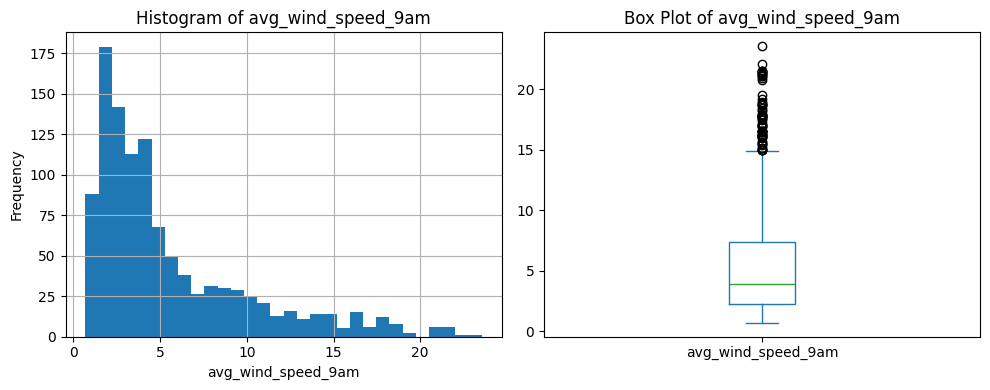

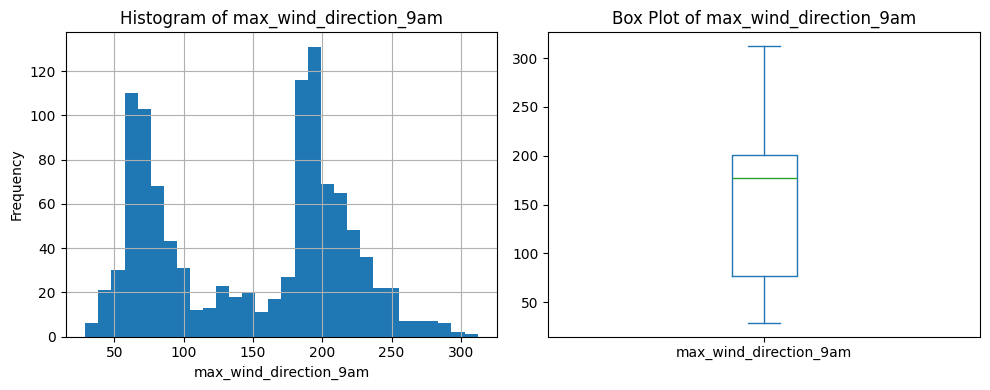

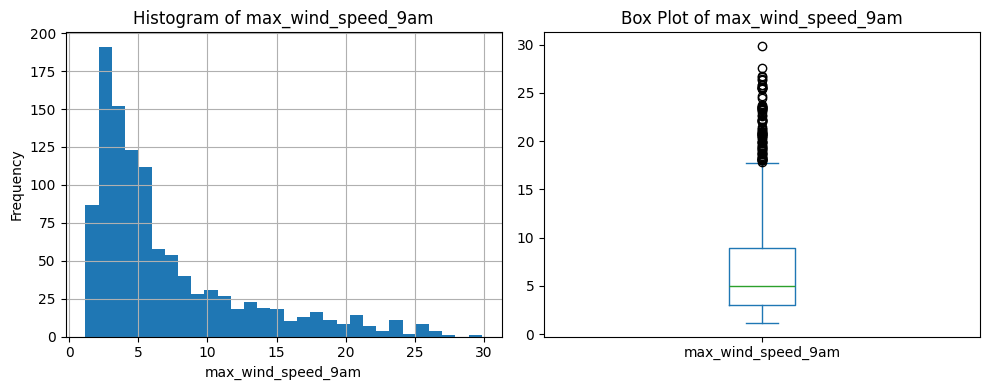

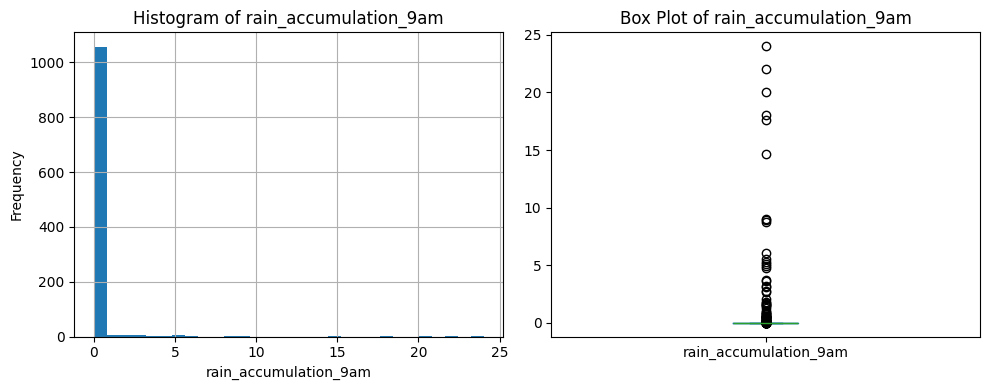

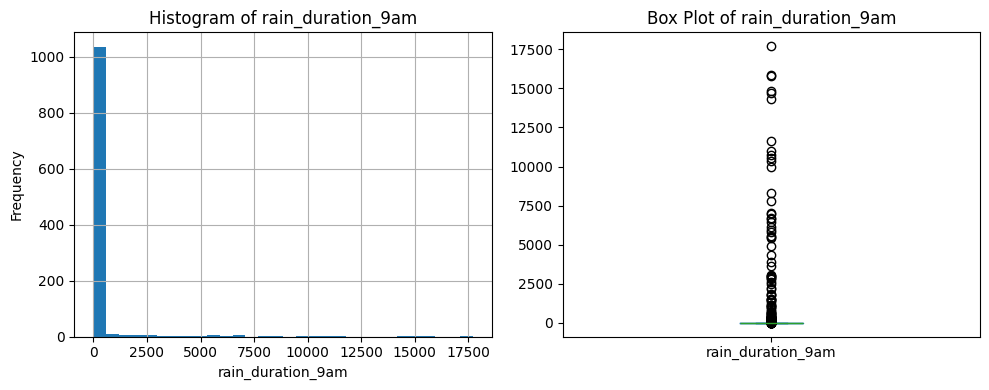

In [ ]:
# Uključujem biblioteku s alatima za crtanje grafova
import matplotlib.pyplot as plt

# Lista stupaca s nedostajućim vrijednostima
missing_cols = [
    'air_pressure_9am', 'air_temp_9am', 'avg_wind_direction_9am',
    'avg_wind_speed_9am', 'max_wind_direction_9am', 'max_wind_speed_9am',
    'rain_accumulation_9am', 'rain_duration_9am'
]

# Crtanje hostograma i box-plot-a za svaki od tih stupaca
for col in missing_cols:
    plt.figure(figsize=(10, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    weather_df[col].hist(bins=30)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    # Box Plot
    plt.subplot(1, 2, 2)
    weather_df[col].plot(kind='box')
    plt.title(f'Box Plot of {col}')

    plt.tight_layout()
    plt.show()

**Zaključci**:

<ul>
    <li><b>air_pressure_9am</b> - iz histograma je vidljivo da su podaci simetrično i zvonoliko distribuirani, iz box-plot-a je vidljivo da postoji nekoliko outlier.a, ali da su podaci većinom centrirani
    --> nedostajuće vrijednosti zamijenit ću <b>aritmetičkom sredinom</b></li>
    <li><b>air_temp_9am</b> - histogram je pomalo nagnut ulijevo i jako je malo outlier-a --> <b>aritmetička sredina</b></li>
    <li><b>avg_wind_direction_9am</b> - histogram je simetričan, nema outlier-a --> <b>aritmetička sredina</b></li>
    <li><b>avg_wind_speed_9am</b> - histogram asimetričan udesno, na box-plot-u značajna prisutnost outlier-a --> <b>medijan</b></li>
    <li><b>max_wind_direction_9am</b> - histogram je simetričan, nema ekstremnih outlier-a --> <b>aritmetička sredina</b></li>
    <li><b>max_wind_speed_9am</b> - histogram je asimetričan udesno, značajna prisutnost outlier-a --> <b>medijan</b></li>
    <li><b>rain_accumulation_9am</b> - histogram je jako zakrivljen udesno, jako je velika prisutnost outlier-a --> <b>medijan</b></li>
    <li><b>rain_duration_9am</b> - isto kao za prethodnu varijablu --> <b>medijan</b></li>
</ul>

### Analiza asimetrije i spljoštenosti

Kako bih potvrdila gornje zaključke, iskoristit ću dostupne funkcije za računanje mjera (koeficijenata) **asimetrije** (eng. *skewness*) i **spljoštenosti** (eng. *kurtosis*) za svaku od promatranih 8 varijabli.

Asimetrija i spljoštenost ukazuju na odstupanje od normalne razdiobe. Asimetrija ukazuje na odstupanje od simetričnosti, a spljoštenost na "duljinu repova" na ekstremima, tj. prisutnost outlier-a. Što je "zvono" normalne distribucije spljoštenije, to je količina outlier-a veća.

Normalna (općenito, simetrična) razdioba ima koeficijent asimetrije = 0, distribucije "nakošene" udesno imaju koeficijent asimetrije > 0, a nakošene ulijevo < 0. Dakle, što asimetrija više odstupa od nule, to je distribucija manje simetrična. Normalna razdioba ima spljoštenost = 3, što je spljoštenost veća od 3 to je outlier-a više, a što je manja od 3 to je outlier-a manje.

In [ ]:
# Rezultate ću spremiti u strukturu rječnika
# Svakoj varijabli pridružit ću riječnik s ključ : vrijednost parovima
# skewness : vrijednost i kurtosis : vrijednost
rezultati = {}
for col in missing_cols:
    # funkcije koje računaju skewness i kurtosis
    skewness = weather_df[col].skew()
    kurtosis = weather_df[col].kurtosis()
    rezultati[col] = {'skewness': skewness, 'kurtosis': kurtosis}

# Ispis
for col, sk in rezultati.items():
    print(f"{col}:")
    print(f"  Skewness: {sk['skewness']}")
    print(f"  Kurtosis: {sk['kurtosis']}")
    print()

air_pressure_9am:
  Skewness: -0.11598876857586271
  Kurtosis: -0.10851805055601416

air_temp_9am:
  Skewness: -0.21153064625339904
  Kurtosis: -0.5532839924082791

avg_wind_direction_9am:
  Skewness: -0.04291690872810993
  Kurtosis: -0.9604131793829347

avg_wind_speed_9am:
  Skewness: 1.5339587221584448
  Kurtosis: 1.8317913185943442

max_wind_direction_9am:
  Skewness: -0.07302396606928303
  Kurtosis: -1.3736281808376076

max_wind_speed_9am:
  Skewness: 1.5787916797755426
  Kurtosis: 1.9304695808228187

rain_accumulation_9am:
  Skewness: 11.056175405751706
  Kurtosis: 134.6988503251086

rain_duration_9am:
  Skewness: 7.223424450336297
  Kurtosis: 57.71797276423409



Iz danih rezultata, vidim da mogu ostati pri prethodno donesenim zaključcima. Za varijable **avg_wind_speed_9am** i **max_wind_speed_9am** *skewness* je **veća od 1**, pa to već možemo smatrati značajnijim odstupanjem od nule. Za varijable **rain_accumulation_9am** i **rain_duration_9am** *skewness* je puno veća od 0, dakle jako su nakrivljene udesno, što smo bili zaključili i iz histograma.

### Eliminacija nedostajućih vrijednosti

Sada ću nedostajuće vrijednosti u svom *dataset*-u zamijeniti sukladno donesenim zaključcima.

Odabrane metode zamjene ću odgovarajućim varijablama "pridružiti" s pomoću **strukture rječnika**.

Zatim ću nedostajuće vrijednosti u odgovarajućim stupcima u DataFrame-u popuniti odgovarajućim vrijednostima aritmetičke sredine ili medijana, koje ću dobiti primjenom funkcija **.mean()** ili **.median()** na stupce DataFrame-a.

Nakon toga, provjerit ću jesu li stvarno sve nedostajuće vrijednosti iz stupaca DataFrame-a eliminirane.


In [ ]:
# Pridruživanje odabranih "metoda" eliminacije stupcima
metoda_zamjene = {
    'air_pressure_9am': 'mean',
    'air_temp_9am': 'mean',
    'avg_wind_direction_9am': 'mean',
    'avg_wind_speed_9am': 'median',
    'max_wind_direction_9am': 'mean',
    'max_wind_speed_9am': 'median',
    'rain_accumulation_9am': 'median',
    'rain_duration_9am': 'median',
}

# Računanje odgovarajućih statističkih vrijednosti,
# i zamjena nedefiniranih vrijednosti u stupcima
for col, mean_ili_medijan in metoda_zamjene.items():
    if mean_ili_medijan == 'mean':
        weather_df[col].fillna(weather_df[col].mean(), inplace=True)
    elif mean_ili_medijan == 'median':
        weather_df[col].fillna(weather_df[col].median(), inplace=True)

# Provjera je li "novi" dataset bez nedefiniranih vrijednosti
# Ova metoda broji nedefinirane vrijednosti u svakom stupcu DataFrame-a
print(weather_df.isnull().sum())


air_pressure_9am          0
air_temp_9am              0
avg_wind_direction_9am    0
avg_wind_speed_9am        0
max_wind_direction_9am    0
max_wind_speed_9am        0
rain_accumulation_9am     0
rain_duration_9am         0
relative_humidity_9am     0
relative_humidity_3pm     0
dtype: int64


## Određivanje "Target"-a za klasifikaciju

Za klasifikaciju podataka potrebno je, naravno, imati definirane **klase u koje ćemo ih klasificirati**, tzv. "target" algoritama strojnog učenja. Primijetimo da **u preuzetom *dataset*-u** nemamo nikakve indikacije o tome koju bismo klasifikaciju trebali provesti nad tim podacima. Podacima **nikakve klase nisu dodijeljene**, **niti je dana uputa koje klase bismo trebali definirati**.

Ja sam, na početku ovog rada, **na temelju naziva varijabli** (svojstava) čije su vrijednosti dane podacima u *dataset*-u, zaključila da bi na temelju njihovih vrijednosti vrijeme određenog dana mogla klasificirati kao ***Sunčano*** (jer imamo podatke o temperaturi i vlažnosti zraka), ***Vjetrovito*** (jer imamo podatke o brzini vjetra), ***Kišovito*** (jer imamo podatke o trajanju kiše i količini padaline), te ***Oblačno*** (jer bi vlažnost u zraku i niža temperatura, a nedostatak kiše mogli npr. ukazivati na približavanje kiše, tj. na oblačno vrijeme, odnosno u tu bismo klasu mogli smjestiti sve preostale podatke koji vjerojatno ne spadaju u ove prve tri kategorije "ekstremnijih" uvjeta).

Za uopće definiranje klasa, **ove moje pretpostavke nisu dovoljne dok ne analiziramo dane podatke**. Na primjer, možda je u svim danim podacima količina kiše velika, a možda je svaki od danih dana suh (iako onda vjerojatno ne bi imalo smisla da je ta varijabla uopće uključena u podatke), pa klasu *Kišovito* ne bi imalo smisla ni uzimati kao moguću klasu.

Zato bismo trebali **vizualizirati** dane **podatke** i **izračunati deskriptivne statistike** danih **varijabli** kako bismo vidjeli kako su točno one **distribuirane**. Mogli bismo onda **odrediti relevantne raspone vrijednosti svake varijable koji će odgovarati različitim klasama**. Također, bilo bi značajno vidjeti kako su **dane varijable međusobno korelirane**, kako bismo zaključili koje raspone vrijednosti kojih varijabli pridružiti **istoj klasi**, pa time i koje je **varijable dovoljno uzeti u obzir za klasifikaciju, a koje možemo zanemariti, jer bi dale jednaku klasifkaciju**.

Konačno, da bismo pojednostavnili posao, razmislimo koje su od danih varijabli najznačajnije za određivanje vremena, tako da analiziramo samo njih, a one od danih 10 varijabli za koje mislimo da nisu značajne uopće ne promatramo. Za ovo bi bilo dobro da smo **stručni u ovoj domeni**, ali koristit ću **zdravorazumske pretpostavke i opće znanje**.

Meni se, od danih varijabli, **za klasifikaciju najznačajnija čini relative_humidity_3pm**, dakle **relativna vlažnost zraka do tri sata popodne**. Naime, vlažnost zraka (i to do tri popodne) vjerojatno jako dobro ukazuje na to je li vrijeme tog dana sunčano, kišovito ili je pred kišu. Ukoliko u podacima stvarno imamo veliki raspon vrijednosti ove varijable, i to od jako niske do visoke, mogli bismo odrediti raspone za "nisku", "umjerenu" i "visoku" vlažnost, i tim klasama vlažnosti pridružiti redom klase sunčanog, oblačnog i kišovitog vremena. Dakle, **možda bi nam već klasifikacija samo po ovoj varijabli mogla biti dovoljna za klasifikaciju podataka**.

Dakle, sigurno ću crtati histogram i računati deskriptivne statistike za varijablu **relative_humidity_3pm**. To ću ipak napraviti i za varijable **air_temp_9am** (iako je samo do 9 ujutro), **rain_accumulation_9am**, **rain_duration_9am** i **avg_wind_speed_9am**, jer bi njihove vrijednosti (i kombinacije njihovih vrijednosti) trebale značajno ukazivati na **poprilično različite vremenske prilike**, tj. na to je li **vrijeme iznimno sunčano, iznimno kišovito ili iznimno vjetrovito**. Prosječni dnevni tlak zraka mi se, recimo, ne čini relevantan.

### Histogrami

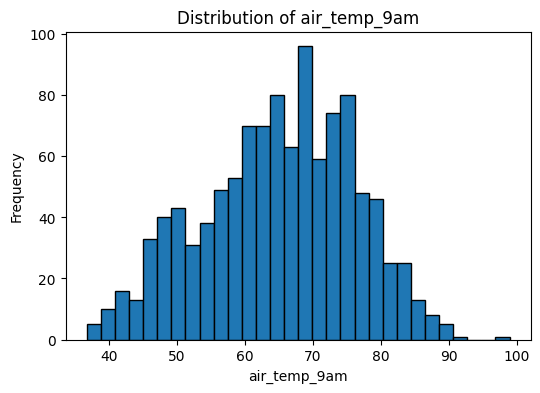

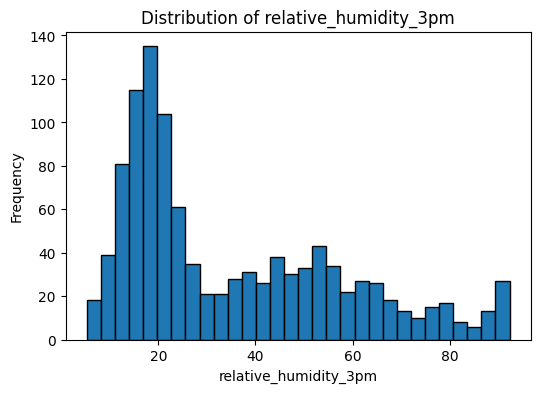

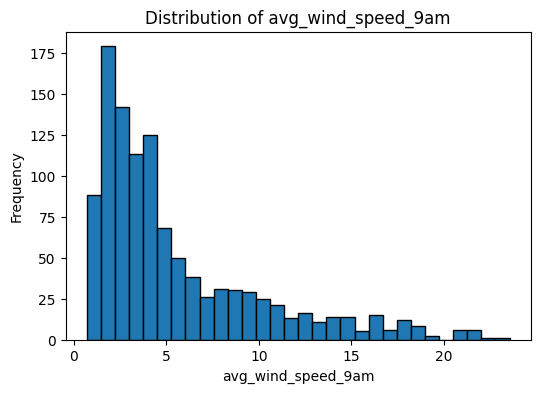

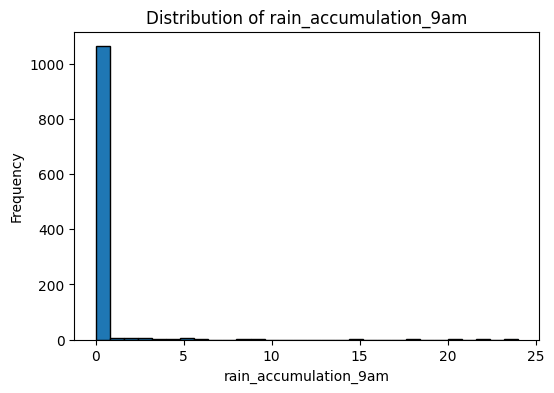

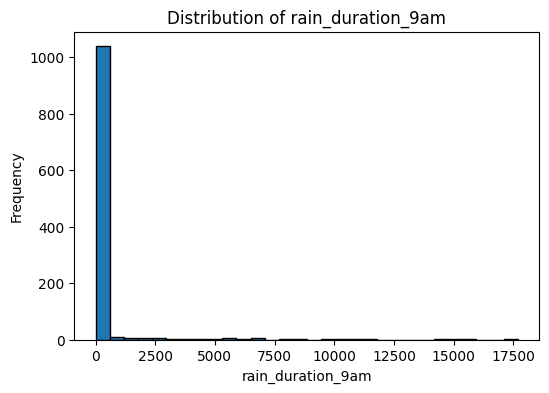

In [ ]:
import matplotlib.pyplot as plt

# Svojstva/varijable koje ću analizirati
varijable = ['air_temp_9am', 'relative_humidity_3pm', 'avg_wind_speed_9am', 'rain_accumulation_9am', 'rain_duration_9am']

# Crtanje histograma za svaku tu varijablu
for v in varijable:
    plt.figure(figsize=(6, 4))
    weather_df[v].hist(bins=30, edgecolor='black')
    plt.title(f'Distribution of {v}')
    plt.xlabel(v)
    plt.ylabel('Frequency')
    plt.grid(False)
    plt.show()


Iz gornjih histograma vidimo da su distribucije i rasponi vrijednosti varijabli air_temp_9am, relative_humidity_3pm i avg_wind_speed_9am relativno pogodne i relevantne za klasifikaciju, tj. **možemo njihove vrijednosti klasificirati u više različitih klasa**, međutim **gotovo je kod svih podataka, tj. dana, akumualcija kiše i trajanje kiše jednako nula**, pa tu varijablu možda nema smisla promatrati.

Izračunajmo još i **deskriptivne statistike** za **sve** varijable u *dataset*-u.

### Deskriptivne statistike

In [ ]:
# Računanje i ispis deskriptivnih statistika
print(weather_df.describe())

       air_pressure_9am  air_temp_9am  avg_wind_direction_9am  \
count       1095.000000   1095.000000             1095.000000   
mean         918.882551     64.933001              142.235511   
std            3.179792     11.149947               69.011349   
min          907.990000     36.752000               15.500000   
25%          916.565752     57.353000               66.109634   
50%          918.900000     65.678000              165.736408   
75%          921.160000     73.435920              190.900000   
max          929.320000     98.906000              343.400000   

       avg_wind_speed_9am  max_wind_direction_9am  max_wind_speed_9am  \
count         1095.000000             1095.000000         1095.000000   
mean             5.503799              148.953518            7.011930   
std              4.547373               67.145759            5.589370   
min              0.693451               28.900000            1.185578   
25%              2.254120               76.663570

### Kvartili

Ono što, pored histograma, iz deskriptivnih statistika možemo dodatno uočiti su konkretne vrijednosti **donjeg, srednjeg i gornjeg kvartila** svake varijable u *dataset*-u, koje, dakle, dijele skup svih vrijednosti odgovarajuće varijable na **četiri segmenta jednake duljine**. Dakle, da ne nagađamo i ne analiziramo previše, **upravo bismo kvartile mogli uzeti kao granice raspona u koje ćemo klasificirati vrijednosti svake pojedine varijable**. Te će nam klasifikacije onda pomoći pri konačnoj klasifikaciji podataka.

### Matrica korelacije

Sada ću **provjeriti međusobnu koreliranost** svih varijabli u *dataset*-u, računajući matricu korelacije koristeći funkciju **.corr()** na DataFrame-u i vizualizirajući matricu koristeći biblioteku **seaborn**.

**Boja** odgovarajućeg elementa matrice će biti **toplija** što je **koreliranost pozitivnija**, a **hladnija** što je **koreliranost negativnija**. Dakle, **intenzitet** boje će biti veći što koreliranost više **odstupa od nule** prema -1 ili 1.

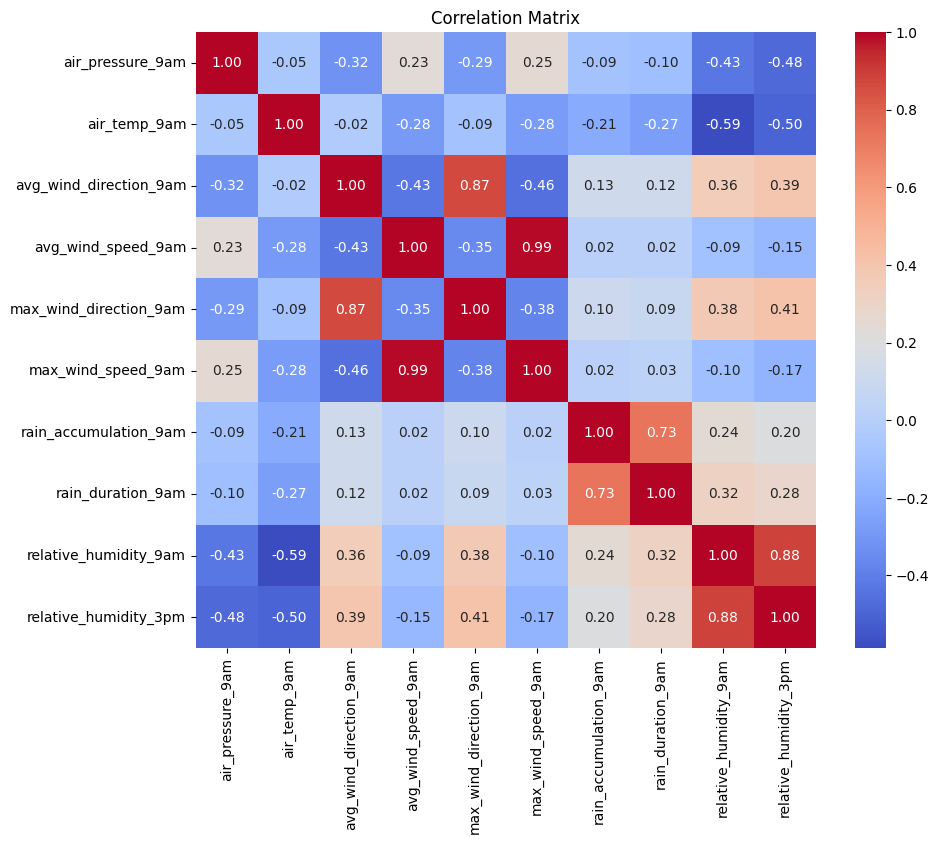

In [ ]:
# Biblioteka seaborn
import seaborn as sns

# Računanje matrice korelacije
correlation_matrix = weather_df.corr()

# Vizualizacija matrice
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


Međusobna koreliranost varijabli, dakle, može nam pomoći zaključiti **koje raspone vrijednosti kojih varijabli bismo trebali pridružiti istoj klasi**, kao i **koje varijable klasificiraju podatke na jednak način**, pa možemo promatrati samo jednu od njih.

Gledajući toplinu i intenzitet boja na matrici, možemo odmah uočiti **očekivane i intuitivne rezultate**.

Relativna dnevna vlažnost zraka do 9 ujutro i relativna vlažnost zraka do 3 popodne su međusobno jako pozitivno korelirane (0.88), što je i razumljivo, jer vlažnost zraka ne varira previše tijekom istog dana. Dakle, **dovoljno je** od njih dviju, na primjer, promatrati samo **relative_humidity_3pm**, za koju smo već ustanovili da ćemo je svakako promatrati. Nadalje, akumulacija kiše do 9 ujutro i trajanje kiše do 9 ujutro su umjereno pozitivno korelirane, što je također razumno i očekivano. Također, visoko su pozitivno korelirane prosječna i maksimalna brzina vjetra, te prosječni i maksimalani smjer vjetra, pa je **dovoljno** promatrati **po jednu među njima**.

Nadalje, značajno je i da su relativna vlažnost zraka do 3 popodne (naravno, i ona do 9 ujutro, i to, naravno, malo jače) i temperatura zraka do 9 ujutro značajno negativno korelirane (-0.50), što je opet očekivano, jer toplije vrijeme prati vlažniji zrak. Dakle, **obje ćemo ove varijable uzeti u obzir pri klasifikaciji i promatrati ih zajedno**.

Konačno, uočimo i da **tlak zraka** zbilja **nije značajan za klasifikaciju**, jer mu je koreliranost sa svim ostalim varijablama gotovo jednaka nula.




### Konačni zaključci, definicija klasa i klasifikacija danih podataka

### Logički uvjeti za svaku klasu

Na temelju svega do sada rečenog, intuicije i statističke analize, klasificirat ćemo podatke na temelju raspona u kojima se nalaze vrijednosti **pet varijabli za koje smo od početka smatrali da su najrelevantnije**: relative_humidity_3pm, air_temp_9am, rain_accumulation_9am, rain_duration_9am i avg_wind_speed_9am.

Kao što sam predlagala na početku za vlažnost, vrijednosti svake od ovih varijabli najprije ćemo klasificirati u tri klase: "**niska**", "**umjerena**" i "**visoka**" vrijednost. Za granice pripadnih raspona uzet ćemo **donji** i **gornji** kvartil odgovarajuće varijable. Tako ćemo, dakle, sve vrijednosti **ispod 25%-kvartila** smatrati (proglasiti) **niskima**, a sve vrijednosti **iznad 75%-kvartila visokima**.

### **Klase**

Definirat ćemo sljedećih **5 klasa na sljedeće načine**:

1.   **Sunčano (Sunny)**


  *   visoka temperatura zraka (air_temp_9am > 73.43)
  *   niska vlažnost zraka relative_humidity_3pm < 17.39


2.   **Oblačno (Cloudy)**


*   umjerena vlažnost (17.39 <= relative_humidity_3pm <= 52.06)
*   **nema kiše** (rain_accumulation_9am = 0 ili rain_duration_9am = 0)

3. **Kišovito (Rainy)**


*   visoka vlažnost (relative_humidity_3pm > 52.06)
*   **bilo kakva naznaka kiše**  (rain_accumulation_9am > 0 ili rain_duration_9am > 0)

4. **Vjetrovito (Windy)**


*   visoka brzina vjetra (avg_wind_speed_9am >= 7.32)

5. **Suho (Dry)**


*   niska vlažnost (relative_humidity_3pm < 17.39)
*   **nema kiše** (rain_accumulation_9am = 0 ili rain_duration_9am = 0)


Napišimo to direktno kao funkciju u Python-u:









In [ ]:
# Klasifikacija retka na temelju odabranih klasa i definiranih pripadnih logičkih uvjeta
def klasifikacija(row):
    if row['air_temp_9am'] > 73.43 and row['relative_humidity_3pm'] < 17.39:
        return 'Sunny'
    elif 17.39 <= row['relative_humidity_3pm'] <= 52.06 and row['rain_accumulation_9am'] == 0 and row['rain_duration_9am'] == 0:
        return 'Cloudy'
    elif row['relative_humidity_3pm'] > 52.06 and (row['rain_accumulation_9am'] > 0 or row['rain_duration_9am'] > 0):
        return 'Rainy'
    elif row['avg_wind_speed_9am'] >= 7.32:
        return 'Windy'
    elif row['relative_humidity_3pm'] < 17.39 and row['rain_accumulation_9am'] == 0 and row['rain_duration_9am'] == 0:
        return 'Dry'
    else:
        return 'Uncategorized'


Uočimo da poredak *if*-ova u gornjoj funkciji određuje **prioritete po kojima se podacima dodjeljuju klase**. Također, time je osigurano da **svaki redak pripada samo jednoj klasi**.


Sada ćemo naše podatke klasificirati **dodavanjem novog stupca u *dataset*** s nazivom **weather_class** i vrijednostima gornje funkcije za svaki redak, dakle s naznakom pripadne klase.

In [ ]:
# Klasifikacija cijelog datset-a
weather_df['weather_class'] = weather_df.apply(klasifikacija, axis=1)

Provjerimo sada raspodjelu klasa po podacima:

In [ ]:
# Provjera raspodjele klasa po podacima
print(weather_df['weather_class'].value_counts())

weather_class
Cloudy           499
Uncategorized    201
Windy            163
Dry               88
Rainy             84
Sunny             60
Name: count, dtype: int64


Vidimo da ovim pristupom **imamo puno** (više od 200) **neklasificiranih redaka**, dakle ovime nije jedinstveno određena klasa za svaki redak.

Zato ćemo malo **relaksirati gornje uvjete**, **dok ne dobijemo klasifikaciju svih podataka**.

### **Relaksirani uvjeti za definiciju klasa**

Najprije, kao što sam rekla **na početku samog rada**, intuitivno je klasu ***Oblačno*** smatrati najneutralnijom, tj. **najopćenitijom klasom**. Zato ću sve na kraju **preostale neklasificirane podatke smjestiti u tu klasu**. Time ćemo svakako **izbjeći neklasificirane podatke**.

Također, relaksirat ću malo uvjete na ostale klase, da **obuhvate više podataka**, tj. redaka.

In [ ]:
# Klasifikacija retka na temelju odabranih klasa i definiranih pripadnih logičkih uvjeta
def klasifikacija1(row):
    # staviti Kišovito kao prioritet
    if row['relative_humidity_3pm'] > 52.06 and (row['rain_accumulation_9am'] > 0 or row['rain_duration_9am'] > 0):
        return 'Rainy'
    # sljedeće Sunčano - malo proširiti prag za temperaturu, a ograničiti za vlažnost
    elif row['air_temp_9am'] > 50 and row['relative_humidity_3pm'] < 15:
        return 'Sunny'
    # Vjetrovito - smanjiti granicu s gornjeg kvartila na aritmetičku sredinu (= 5.5)
    elif row['avg_wind_speed_9am'] >= 5.5:
        return 'Windy'
    # Oblačno - staviti tek ovdje po prioritetu
    elif 17.39 <= row['relative_humidity_3pm'] <= 52.06 and row['rain_accumulation_9am'] == 0 and row['rain_duration_9am'] == 0:
        return 'Cloudy'
    elif row['relative_humidity_3pm'] < 15 and row['rain_accumulation_9am'] == 0 and row['rain_duration_9am'] == 0:
        return 'Dry'
    else:
        # SVE PREOSTALE DOSAD NEKLASIFICIRANE PODATKE SMJESTITI U Oblačno
        return 'Cloudy'

weather_df = weather_df.drop(['weather_class'], axis=1)
# Za svaki slučaj opet učitati originalne podatke -> ne, nan vrijednosti!!!
#weather_df = pd.read_csv('daily_weather.csv')
#weather_df = weather_df.drop(['number'], axis=1)

# Klasifikacija cijelog datset-a (relaksirana)
weather_df['weather_class'] = weather_df.apply(klasifikacija1, axis=1)

# Provjera raspodjele klasa po podacima
print(weather_df['weather_class'].value_counts())

weather_class
Cloudy    623
Windy     208
Sunny     180
Rainy      84
Name: count, dtype: int64


## Varijable i target

Odvojimo sada sve stupce iz *dataset*-a koji predstavljaju **varijable**, tj. svojstva, u **DataFrame X**, a "**target**", tj. stupac s klasifikacijom, izvojimo u **vektor-stupac y**.



In [ ]:
# varijable
X = weather_df.drop(columns=['weather_class'])
# target
y = weather_df['weather_class']

Provjerimo dimenzije:

In [ ]:
print("Oblik X:", X.shape)
print("Oblik y:", y.shape)

Oblik X: (1095, 10)
Oblik y: (1095,)


## Skup za treniranje i skup za testiranje

Sada dijelimo naše podatke, i varijable i target, na odgovarajuće skupove za treniranje i za testiranje. Standardno se za treniranje uzima 70-80% podataka, a, dakle, 20-30% se ostavlja za testiranje istreniranog modela.

Primjerice, neka je 20% podataka izdvojeno za testiranje, i neka je seed npr. 42.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Balansiranje raspodjele klasa

Iz gornjeg rezultata je vidljivo da klase nisu ravnomjerno raspoređene po podacima. Štoviše, kao što je bilo i očekivano, klasa ***Oblačno* značajno dominira**.

Vizualizirajmo to i grafički:



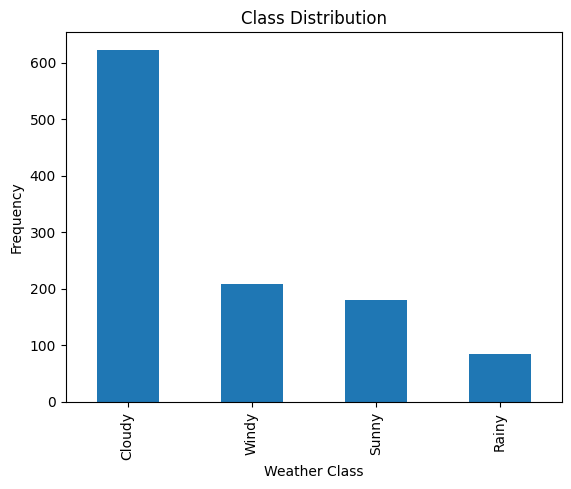

In [ ]:
# Graf koji prikazuje raspodjelu klasa u *dataset*-u
weather_df['weather_class'].value_counts().plot(kind='bar', title='Class Distribution')
plt.xlabel('Weather Class')
plt.ylabel('Frequency')
plt.show()

Algoritmi klasifikacije bi, prilikom **treniranja na ovim podacima**, mogli postati **pristrani dominantnoj klasi** i **previše zanemariti utjecaj preostalih klasa**.

Zbog toga se standardno podaci najprije uravnotežuju po klasama.

Sljedeći postupak (***oversampling***) **generira sintetičke podatke**, na temelju interpolacije postojećih podataka u *dataset*-u, koji će **pripadati manje zastupljenim klasama**, kako bi se klase uravnotežile među podacima.

**Napomena.** Ovo se provodi samo na podacima **za treniranje**, a ne i na onima na kojima ćemo kasnije testirati model.

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# 42 je standardni seed, postavlja se radi reproducibilnosti generiranih podataka
smote = SMOTE(random_state=42)

# Provođenje oversampling-a
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Provjera raspodjele klasa na proširenim podacima
print("Class distribution after SMOTE:", Counter(y_train_resampled))


Class distribution after SMOTE: Counter({'Cloudy': 488, 'Rainy': 488, 'Windy': 488, 'Sunny': 488})


## Skaliranje podataka prije treniranja modela

Vidjeli smo u prethodno provedenim analizama da neke od danih varijabli poprimaju jako mali raspon vrijednosti, a neke jako veliki.

Budući da se ***k-NN* algoritam temelji na usporedbi udaljenosti podataka**, ove velike razlike u rasponima vrijednosti mogle bi izazvati greške i pristranosti.

Stoga se, standardno, svi **numerički** podaci **skaliraju prije treniranja i testiranja**, primjerice tako da sve varijable, tj. stupci, slijede **normalnu razdiobu**.

Sljedećim postupkom se svi **numerički** podaci u našem *dataset*-u skaliraju tako da imaju očekivanje 0 i standardnu devijaciju 1.


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Skaliranje varijabli u X_train
X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
# Skaliranje varijabli u X_test
X_test_scaled = scaler.fit_transform(X_test)

# Provjera
print("Skalirane varijable (prvih 5 redaka):\n", X_train_resampled_scaled[:5])


Skalirane varijable (prvih 5 redaka):
 [[-1.0486859   0.81254518  0.5666232  -0.72118916  0.58172504 -0.75050383
  -0.2200859  -0.29455287 -0.99196967 -0.69238095]
 [-0.71839704  0.7092004   0.8090366  -0.87935963  0.89962869 -0.90011604
  -0.2200859  -0.29455287 -0.48557498 -0.15349882]
 [-0.95315463  0.73035197 -0.3206013  -1.07125764 -0.55218943 -1.04546027
  -0.2200859  -0.28691293  1.02246915  0.95354413]
 [-0.50895993  0.4280835   0.06210969 -1.09346692  1.11507175 -1.0586084
  -0.2200859  -0.29455287 -0.84963412 -0.7078984 ]
 [-0.57246665 -1.57842294  1.03553041  0.18277353  1.08983618  0.0373542
  -0.2200859  -0.29455287  1.70227644  1.79936639]]


## **Naive Bayes** (gaussovski)

Kao na predavanju, primjenjujemo Naive Bayes algoritam na skupu podatka za treniranje.

Za naše podatke, ako gledamo vrijednosti, nije pogodan ni Bernoullijev ni multinomni, već **gaussovski Naive Bayes** algoritam.

Model učimo funkcijom **.fit()**.

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score

# Trening Naive Bayes modela
# GAUSSOVSKI NAIVE BAYES iz pripadnog modula u Scikit-learn biblioteci
nb_model = GaussianNB()
nb_model.fit(X_train_resampled_scaled, y_train_resampled)

GaussianNB()

Zatim primjenjujemo model na skup podataka za testiranje, tj., na temelju naučenog, procjenjujemo njihove klase, funkcijom **.predict()**.

In [ ]:
# Primjena modela na testnim podacima --> predviđanje klasifikacije
y_pred_nb = nb_model.predict(X_test_scaled)

Konačno, istrenirani model evaluiramo metrikom **accuracy_score** koja utvrđuje postotak uspješnosti, tj. ispravno klasificiranih testnih podataka, uspoređujući rezultate koje je dao model s testnim target-om.

In [ ]:
# Evaluacija modela metrikom
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))

Naive Bayes Accuracy: 0.593607305936073


## **k-NN algoritam**

Konačno, analogno, primjenjujemo k-NN algoritam na skupu podataka za treniranje.

Za **parametre algoritma**, ovdje uzimamo **k = 5 susjeda**, jer je to standardno, budući da "nije ni premalo ni previše" (jer, kao što smo rekli na predavanju,  općenito, veća vrijednost parametra k potiskuje učinke šuma, ali čini granice klasifikacije manje jasnima/uočljivima), te **weights = unform** opciju, s kojom **svi podaci imaju istu težinu**.

Model ponovno učimo funkcijom **.fit()**.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Trening k-NN modela s k = 5 susjeda i opcijom weights = uniform
knn_model_5u = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn_model_5u.fit(X_train_resampled_scaled, y_train_resampled)


KNeighborsClassifier()

Primjenjujemo model na skup podataka za testiranje, tj., na temelju naučenog, procjenjujemo njihove klase, funkcijom **.predict()**:

In [ ]:
# Primjena modela na testnim podacima --> predviđanje klasifikacije
y_pred_knn_5u = knn_model_5u.predict(X_test_scaled)

I, konačno, računamo i njegov **accuracy_score**:

In [ ]:
# Evaluacija modela metrikom
print("k-NN (5, uniform) Accuracy:", accuracy_score(y_test, y_pred_knn_5u))

k-NN (5, uniform) Accuracy: 0.6712328767123288


In [ ]:
# Trening k-NN modela s k = 5 susjeda i opcijom weights = distance
knn_model_5d = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn_model_5d.fit(X_train_resampled_scaled, y_train_resampled)


KNeighborsClassifier(weights='distance')

In [ ]:
# Primjena modela na testnim podacima --> predviđanje klasifikacije
y_pred_knn_5d = knn_model_5d.predict(X_test_scaled)
# Evaluacija modela metrikom
print("k-NN (5, distance) Accuracy:", accuracy_score(y_test, y_pred_knn_5d))

k-NN (5, distance) Accuracy: 0.6666666666666666
